<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/w1d2_updates/tutorials/W1D2_LinearDeepLearning/W1D2_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# DL Neuromatch Academy: Week 1, Day 2, Tutorial 2
# Deep Linear Neural Networks

__Content creators:__ Andrew Saxe, Saeed Salehi, Vladimir Haltakov



__Content reviewers:__ Polina Turishcheva, Atnafu Lambebo, Yu-Fang Yang

__Content editors:__ Anoop Kulkarni

__Production editors:__ Khalid Almubarak, , Spiros Chavlis

---
#Tutorial Objectives

* Training landscape
* The effect of depth
* Choosing a learning rate
* Initialisation matters


In [1]:
#@markdown Tutorial slides
# you should link the slides for all tutorial videos here (we will store pdfs on osf)

from IPython.display import HTML
HTML('<iframe src="https://docs.google.com/presentation/d/1kfWWYhSIkczYfjebhMaqQILTCu7g94Q-o_ZcWb1QAKs/embed?start=false&loop=false&delayms=3000" frameborder="0" width="960" height="569" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>')

---
# Setup


In [2]:
# Imports

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# @title Figure settings
# import ipywidgets as widgets
# from ipywidgets import interact, fixed, HBox, Layout, VBox, interactive, Label
from ipywidgets import interact, IntSlider, FloatSlider, interact_manual
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [4]:
#@title Plotting functions

def plot_x_y_(x_t_, y_t_, x_ev_, y_ev_, loss_log_, weight_log_):
  """
  """
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 3, 1)
  plt.scatter(x_t_, y_t_, c='r', label='training data')
  plt.plot(x_ev_, y_ev_, c='b', label='test results', linewidth=2)
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()
  plt.subplot(1, 3, 2)
  plt.plot(loss_log_, c='r')
  plt.xlabel('epochs')
  plt.ylabel('mean squared error')
  plt.subplot(1, 3, 3)
  plt.plot(weight_log_)
  plt.xlabel('epochs')
  plt.ylabel('weights')
  plt.show()

def plot_vector_field(what, init_weights=None):
  """
  """
  n_epochs=40
  lr=0.15
  x_pos = np.linspace(2.0, 0.5, 100, endpoint=True)
  y_pos = 1. / x_pos
  xx, yy = np.mgrid[-1.9:2.0:0.2, -1.9:2.0:0.2]
  zz = np.empty_like(xx)
  x, y = xx[:, 0], yy[0]

  x_temp, y_temp = gen_samples(10, 1.0, 0.0)

  cmap = matplotlib.cm.plasma
  plt.figure(figsize=(7, 7))

  if what == 'all' or what == 'vectors':
    for i, a in enumerate(x):
      for j, b in enumerate(y):
        temp_model = ShallowNarrowLNN([a, b])
        da, db = temp_model.dloss_dw(x_temp, y_temp)
        zz[i, j] = temp_model.loss(temp_model.forward(x_temp), y_temp)
        scale = min(40 * np.sqrt(da**2 + db**2), 50)
        plt.quiver(a, b, - da, - db, scale=scale, color=cmap(np.sqrt(da**2 + db**2)))

  if what == 'all' or what == 'trajectory':
    if init_weights is None:
      for init_weights in [[0.5, -0.5], [0.55, -0.45], [-1.8, 1.7]]:
        temp_model = ShallowNarrowLNN(init_weights)
        _, temp_records = temp_model.train(x_temp, y_temp, lr, n_epochs)
        plt.scatter(temp_records[:, 0], temp_records[:, 1],
                    c=np.arange(len(temp_records)), cmap='Greys')
        plt.scatter(temp_records[0, 0], temp_records[0, 1], c='blue', zorder=9)
        plt.scatter(temp_records[-1, 0], temp_records[-1, 1], c='red', marker='X', s=100, zorder=9)
    else:
        temp_model = ShallowNarrowLNN(init_weights)
        _, temp_records = temp_model.train(x_temp, y_temp, lr, n_epochs)
        plt.scatter(temp_records[:, 0], temp_records[:, 1],
                    c=np.arange(len(temp_records)), cmap='Greys')
        plt.scatter(temp_records[0, 0], temp_records[0, 1], c='blue', zorder=9)
        plt.scatter(temp_records[-1, 0], temp_records[-1, 1], c='red', marker='X', s=100, zorder=9)

  if what == 'all' or what == 'loss':
    plt.contourf(x, y, np.log(zz+0.001), zorder=-1, cmap='coolwarm', levels=100)
  plt.xlabel("$w_1$")
  plt.ylabel("$w_2$")
  plt.xlim(-1.9, 1.9)
  plt.ylim(-1.9, 1.9)

  plt.show()

def plot_loss_landscape():
  """
  """
  x_temp, y_temp = gen_samples(10, 1.0, 0.0)

  xx, yy = np.mgrid[-1.9:2.0:0.2, -1.9:2.0:0.2]
  zz = np.empty_like(xx)
  x, y = xx[:, 0], yy[0]

  for i, a in enumerate(x):
    for j, b in enumerate(y):
      temp_model = ShallowNarrowLNN([a, b])
      zz[i, j] = temp_model.loss(temp_model.forward(x_temp), y_temp)

  temp_model = ShallowNarrowLNN([-1.8, 1.7])
  loss_rec_1, w_rec_1 = temp_model.train(x_temp, y_temp, 0.02, 240)

  temp_model = ShallowNarrowLNN([1.5, -1.5])
  loss_rec_2, w_rec_2 = temp_model.train(x_temp, y_temp, 0.02, 240)

  plt.figure(figsize=(12, 8))
  ax = plt.subplot(1, 1, 1, projection='3d')
  ax.plot_surface(xx, yy, np.log(zz+0.5), cmap='coolwarm', alpha=0.5)
  ax.scatter3D(w_rec_1[:, 0], w_rec_1[:, 1], np.log(loss_rec_1+0.5),
                c='k', s=50, zorder=9)
  ax.scatter3D(w_rec_2[:, 0], w_rec_2[:, 1], np.log(loss_rec_2+0.5),
                c='k', s=50, zorder=9)
  plt.axis("off")
  ax.view_init(45, 260)

  plt.show()


def depth_widget(depth):
  depth_lr_init_interplay(depth, 0.01, 0.9)


def lr_widget(lr):
  depth_lr_init_interplay(50, lr, 0.9)


def depth_lr_interplay(depth, lr):
  depth_lr_init_interplay(depth, lr, 0.9)


def depth_lr_init_interplay(depth, lr, init_weights):
  n_epochs = 500

  x_train, y_train = gen_samples(100, 2.0, 0.1)
  model = DeepNarrowLNN(np.full((1, depth), init_weights))

  plt.figure(figsize=(10, 5))
  plt.plot(model.train(x_train, y_train, lr, n_epochs),
            linewidth=3.0, c='m')

  plt.title("Training a {}-layer LNN with"
  " $\eta=${} initialized with $w_i=${}".format(depth, lr, init_weights), pad=15)
  plt.yscale('log')
  plt.xlabel('epochs')
  plt.ylabel('Log mean squared error')
  plt.ylim(0.001, 1.0)
  plt.show()


def plot_init_effect():
  depth = 15
  n_epochs = 250
  lr = 0.02

  x_train, y_train = gen_samples(100, 2.0, 0.1)

  plt.figure(figsize=(12, 6))
  for init_w in np.arange(0.7, 1.09, 0.05):
      model = DeepNarrowLNN(np.full((1, depth), init_w))
      plt.plot(model.train(x_train, y_train, lr, n_epochs),
              linewidth=3.0, label="initial weights {:.2f}".format(init_w))
  plt.title("Training a {}-layer narrow LNN with $\eta=${}".format(depth, lr), pad=15)
  plt.yscale('log')
  plt.xlabel('epochs')
  plt.ylabel('Log mean squared error')
  plt.legend(loc='lower left', ncol=4)
  plt.ylim(0.001, 1.0)
  plt.show()

In [5]:
#@title Helper functions

def gen_samples(n: int, a: float, σ: float):
  """generates `n` samples with `y = z * x + noise(σ)` linear relation. """
  assert n > 0
  assert σ >= 0

  if σ > 0:
    x = np.random.rand(n)
    noise = np.random.normal(scale = σ, size=(n))
    y = a * x + noise
  else:
    x = np.linspace(0.0, 1.0, n, endpoint=True)
    y = a * x
  return x, y

class ShallowNarrowLNN:
  """
  Shallow and narrow (one neuron per layer) linear neural network
  """
  def __init__(self, init_ws: list):
    """
    init_ws: initial weights as a list
    """
    assert isinstance(init_ws, list)
    assert len(init_ws) == 2
    self.w1 = init_ws[0]
    self.w2 = init_ws[1]


  def forward(self, x: np.ndarray):
    """
    The forward pass through netwrok y = x * w1 * w2
    """
    y = x * self.w1 * self.w2
    return y


  def loss(self, y_p: np.ndarray, y_t: np.ndarray):
    """
    Mean squared error (L2) with 1/2 for convenience
    """
    assert y_p.shape == y_t.shape
    mse = ((y_t - y_p)**2).mean()
    return mse

  def dloss_dw(self, x: np.ndarray, y_t: np.ndarray):
    """
    partial derivative of loss with respect to weights
    """
    assert x.shape == y_t.shape
    Error = y_t - self.w1 * self.w2 * x
    dloss_dw1 = - (2 * self.w2 * x * Error).mean()
    dloss_dw2 = - (2 * self.w1 * x * Error).mean()
    return dloss_dw1, dloss_dw2

  def train(self, x: np.ndarray, y_t: np.ndarray, η: float, n_ep: int):
    """
    Gradient descent algorithm
    """
    assert x.shape == y_t.shape

    loss_records = np.empty(n_ep)  # pre allocation of loss records
    weight_records = np.empty((n_ep, 2))  # pre allocation of weight records

    for i in range(n_ep):
      y_p = self.forward(x)
      loss_records[i] = self.loss(y_p, y_t)
      dloss_dw1, dloss_dw2 = self.dloss_dw(x, y_t)
      self.w1 -= η * dloss_dw1
      self.w2 -= η * dloss_dw2
      weight_records[i] = [self.w1, self.w2]

    return loss_records, weight_records


class DeepNarrowLNN:
  """
  Deep but thin (one neuron per layer) linear neural network
  """
  def __init__(self, init_ws: np.ndarray):
    """
    init_ws: initial weights as a numpy array
    """
    self.n = init_ws.size
    self.W = init_ws.reshape(1, -1)


  def forward(self, x: np.ndarray):
    """
    x: input features
    """
    y = np.prod(self.W) * x
    return y


  def loss(self, y_t, y_p):
    """
    mean squared error (L2 loss)
    """
    assert y_p.shape == y_t.shape
    mse = ((y_t - y_p)**2 / 2).mean()
    return mse


  def dloss_dw(self, x, y_t, y_p):
    """
    analytical gradient of weights
    """
    E = y_t - y_p  # = y_t - x * np.prod(self.W)
    Ex = np.multiply(x, E).mean()
    Wp = np.prod(self.W) / (self.W + 1e-9)
    dW = - Ex * Wp
    return dW


  def train(self, x, y_t, η, n_epochs):
    """
    training using gradient descent
    """
    loss_records = np.empty(n_epochs)
    loss_records[:] = np.nan
    for i in range(n_epochs):
      y_p = self.forward(x)
      loss_records[i] = self.loss(y_t, y_p).mean()
      dloss_dw = self.dloss_dw(x, y_t, y_p)
      if np.isnan(dloss_dw).any() or np.isinf(dloss_dw).any():
        return loss_records
      self.W -= η * dloss_dw
    return loss_records

In [6]:
#@title Set random seed

#@markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


set_seed(seed=2021, seed_torch=True)  # change 2021 with any number you like

Random seed 2021 has been set.


In [7]:
#@title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [8]:
SEED = 2021
set_seed(seed=SEED) 
DEVICE = set_device()

Random seed 2021 has been set.


---
# Section 1: A shallow Narrow Linear Neural Network

Video available at https://youtu.be/yTBYmFWslZI


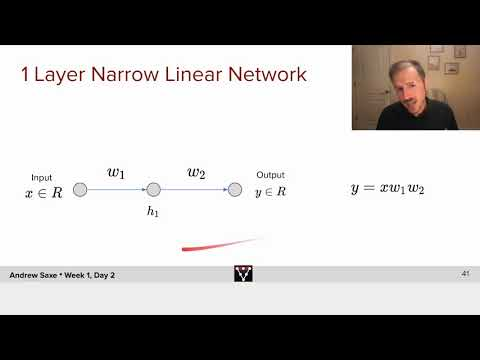

In [9]:
#@title Video 1.1: Shallow Narrow Linear Network
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="yTBYmFWslZI", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Section 1.1:

To better understand the behaviour of a neural network training evolution through gradient descent, we start with the incredibly simple case of shallow narrow linear neural net, since the state of the art models are impossible to dissect and comprehend with our current mathematical tools.

The model we use has two hidden layers, each with only one neuron. We also consider L2-loss as the cost function. As you may have already guessed, we can visualize the model as a neural network:

<center><img src="https://raw.githubusercontent.com/ssnio/statics/main/neuromatch/shallow_narrow_nn.png" width="400"/></center>

<br/>

or by its computation graph:

<center><img src="https://raw.githubusercontent.com/ssnio/statics/main/neuromatch/shallow_narrow.png" alt="Shallow Narrow Graph" width="400"/></center>

or in a rare occasion, even as a reasonably compact mapping:

$$ loss = (y - w_1 \cdot w_2 \cdot x)^2 $$

<br/>


### Exercise 1: Calculate gradients

Once again, we ask you to calculate the network gradients analytically, since you will need them for the next exercise. We understand how annoying this is.

$\dfrac{\partial{loss}}{\partial{w_1}} = ?$

$\dfrac{\partial{loss}}{\partial{w_2}} = ?$

### Exercise 2: Implement the Shallow Narrow LNN

Next, we ask you to implement the `forward` pass for our model from scratch without using PyTorch.

Also, although our model gets a single input feature and outputs a single prediction, we could calculate the loss and perform training for multiple samples at once. This is the common practice for neural networks, since computers are incredibly fast doing matrice (or tensors in general) operations, rather than processing samples through `for` loops. Therefore, for the `loss` function, please implement the **mean** squred error (MSE), and adjust your analytical gradients to accomodate the mean in MSE, while implementing the `dloss_dw` function.

Finally, you should be able to complete the `train` function gradient descent algorithm.


In [10]:
class ShallowNarrowExercise:
  """
  Shallow and narrow (one neuron per layer) linear neural network
  """
  def __init__(self, init_ws: list):
    """
    init_ws: initial weights as a list
    """
    assert isinstance(init_ws, list)
    assert len(init_ws) == 2
    self.w1 = init_ws[0]
    self.w2 = init_ws[1]


  def forward(self, x: np.ndarray) -> np.ndarray:
    """
    The forward pass through netwrok y = x * w1 * w2
    """
    #################################################
    ## Implement the forward pass to calculate prediction
    ## Note that prediction is not the loss
    # Complete the function and remove or comment the line below
    raise NotImplementedError("Forward Pass `forward`")
    #################################################
    y = ...
    return y


  def dloss_dw(self, x: np.ndarray, y_t: np.ndarray):
    """
    partial derivative of loss with respect to weights
    """
    assert x.shape == y_t.shape
    #################################################
    ## Implement the gradient computation function
    # Complete the function and remove or comment the line below
    raise NotImplementedError("Forward Pass `dloss_dw`")
    #################################################
    dloss_dw1 = ...
    dloss_dw2 = ...
    return dloss_dw1, dloss_dw2


  def train(self, x: np.ndarray, y_t: np.ndarray, η: float, n_ep: int):
    """
    Gradient descent algorithm
    """
    assert x.shape == y_t.shape

    loss_records = np.empty(n_ep)  # pre allocation of loss records
    weight_records = np.empty((n_ep, 2))  # pre allocation of weight records

    for i in range(n_ep):
      y_p = self.forward(x)
      loss_records[i] = loss(y_p, y_t)
      dloss_dw1, dloss_dw2 = self.dloss_dw(x, y_t)
      #################################################
      ## Implement the gradient descent step
      # Complete the function and remove or comment the line below
      raise NotImplementedError("Forward Pass `train`")
      #################################################
      self.w1 -= ...
      self.w2 -= ...
      weight_records[i] = [self.w1, self.w2]

    return loss_records, weight_records


def loss(y_p: np.ndarray, y_t: np.ndarray):
  """
  Mean squared error
  """
  assert y_p.shape == y_t.shape
  #################################################
  ## Implement the MEAN squared error
  # Complete the function and remove or comment the line below
  raise NotImplementedError("Forward Pass `loss`")
  #################################################
  mse = ...
  return mse


n_epochs = 211
learning_rate = 0.02
initial_weights = [1.4, -1.6]
x_train, y_train = gen_samples(n=73, a=2.0, σ=0.2)
x_eval = np.linspace(0.0, 1.0, 37, endpoint=True)

# # Uncomment to run
# sn_model = ShallowNarrowExercise(initial_weights)
# loss_log, weight_log = sn_model.train(x_train, y_train, learning_rate, n_epochs)
# y_eval = sn_model.forward(x_eval)

# plot_x_y_(x_train, y_train, x_eval, y_eval, loss_log, weight_log)

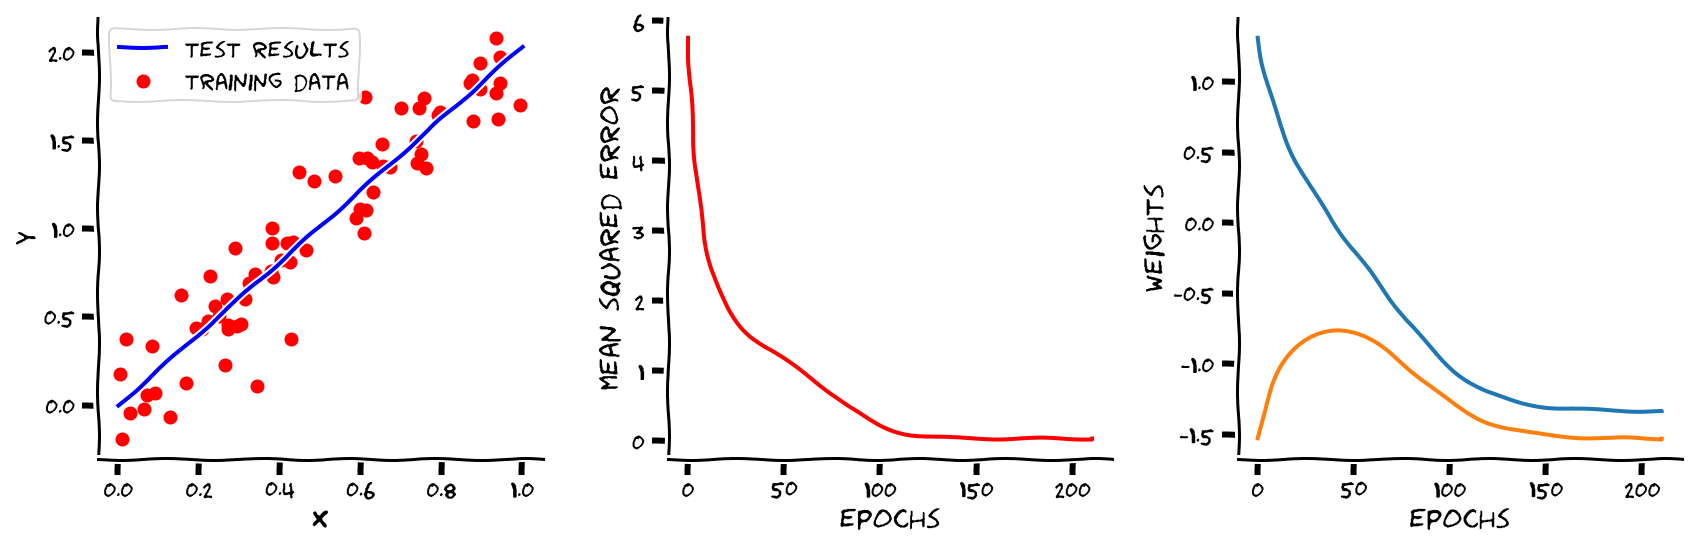

In [11]:
# to_remove solution
class ShallowNarrowExercise:
  """
  Shallow and narrow (one neuron per layer) linear neural network
  """
  def __init__(self, init_ws: list):
    """
    init_ws: initial weights as a list
    """
    assert isinstance(init_ws, list)
    assert len(init_ws) == 2
    self.w1 = init_ws[0]
    self.w2 = init_ws[1]


  def forward(self, x: np.ndarray) -> np.ndarray:
    """
    The forward pass through netwrok y = x * w1 * w2
    """
    y = x * self.w1 * self.w2
    return y


  def dloss_dw(self, x: np.ndarray, y_t: np.ndarray):
    """
    partial derivative of loss with respect to weights
    """
    assert x.shape == y_t.shape
    dloss_dw1 = - (2 * self.w2 * x * (y_t - self.w1 * self.w2 * x)).mean()
    dloss_dw2 = - (2 * self.w1 * x * (y_t - self.w1 * self.w2 * x)).mean()
    return dloss_dw1, dloss_dw2


  def train(self, x: np.ndarray, y_t: np.ndarray, η: float, n_ep: int):
    """
    Gradient descent algorithm
    """
    assert x.shape == y_t.shape

    loss_records = np.empty(n_ep)  # pre allocation of loss records
    weight_records = np.empty((n_ep, 2))  # pre allocation of weight records

    for i in range(n_ep):
      y_p = self.forward(x)
      loss_records[i] = loss(y_p, y_t)
      dloss_dw1, dloss_dw2 = self.dloss_dw(x, y_t)
      self.w1 -= η * dloss_dw1
      self.w2 -= η * dloss_dw2
      weight_records[i] = [self.w1, self.w2]

    return loss_records, weight_records


def loss(y_p: np.ndarray, y_t: np.ndarray):
  """
  Mean squared error
  """
  assert y_p.shape == y_t.shape
  mse = ((y_t - y_p)**2).mean()
  return mse


n_epochs = 211
learning_rate = 0.02
initial_weights = [1.4, -1.6]
x_train, y_train = gen_samples(n=73, a=2.0, σ=0.2)
x_eval = np.linspace(0.0, 1.0, 37, endpoint=True)

# # Uncomment to run
sn_model = ShallowNarrowExercise(initial_weights)
loss_log, weight_log = sn_model.train(x_train, y_train, learning_rate, n_epochs)
y_eval = sn_model.forward(x_eval)

with plt.xkcd():
  plot_x_y_(x_train, y_train, x_eval, y_eval, loss_log, weight_log)

Video available at https://youtu.be/cUzZPYuJfWY


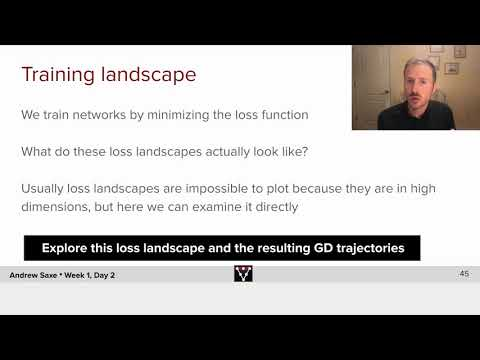

In [12]:
#@title Video 1.2: Training-Landscape
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="cUzZPYuJfWY", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Section 1.3: Training landscape

As you may have already asked yourself, we can analytically find $w_1$ and $w_2$ without using gradient descent:

$$w_1 \cdot w_2 = \dfrac{y}{x} $$

In fact, we can plot the gradients, the loss function and all the solutions in one figure. In this example, we use the $y = 1x$ mapping:

**Blue ribbon**: shows all the possible solutions: $~ w_1 w_2 = \dfrac{y}{x} = \dfrac{x}{x} = 1 \Rightarrow w_1 = \dfrac{1}{w_2}$

**Contour background**: Loss values, red being higher loss

**Vectors filed (arrows)**: the gradient vector field, the larger yellow arrows show larger gradients (stronger fields), which correspond to bigger steps by gradient descent.

**Scatter circles**: the trajectory (evolution) of weights during training for three different initialization, with red crosses ( **x** ) marking the end of training. You can also try your own initializations (keep the initial values between `-2.0` and `2.0`) as shown here:
```python
plot_vector_field('all', [1.0, -1.0])
```

Finally, if the plot is too crowded, feel free to pass one of the following strings as argument:

```python
plot_vector_field('vectors')  # for vector field
plot_vector_field('trajectory')  # for training trajectory
plot_vector_field('loss')  # for loss contour
```

### Exercise 3: The saddle point

Discuss with your pod, everything you see and infer in the next two plots. Can you find the saddle point?

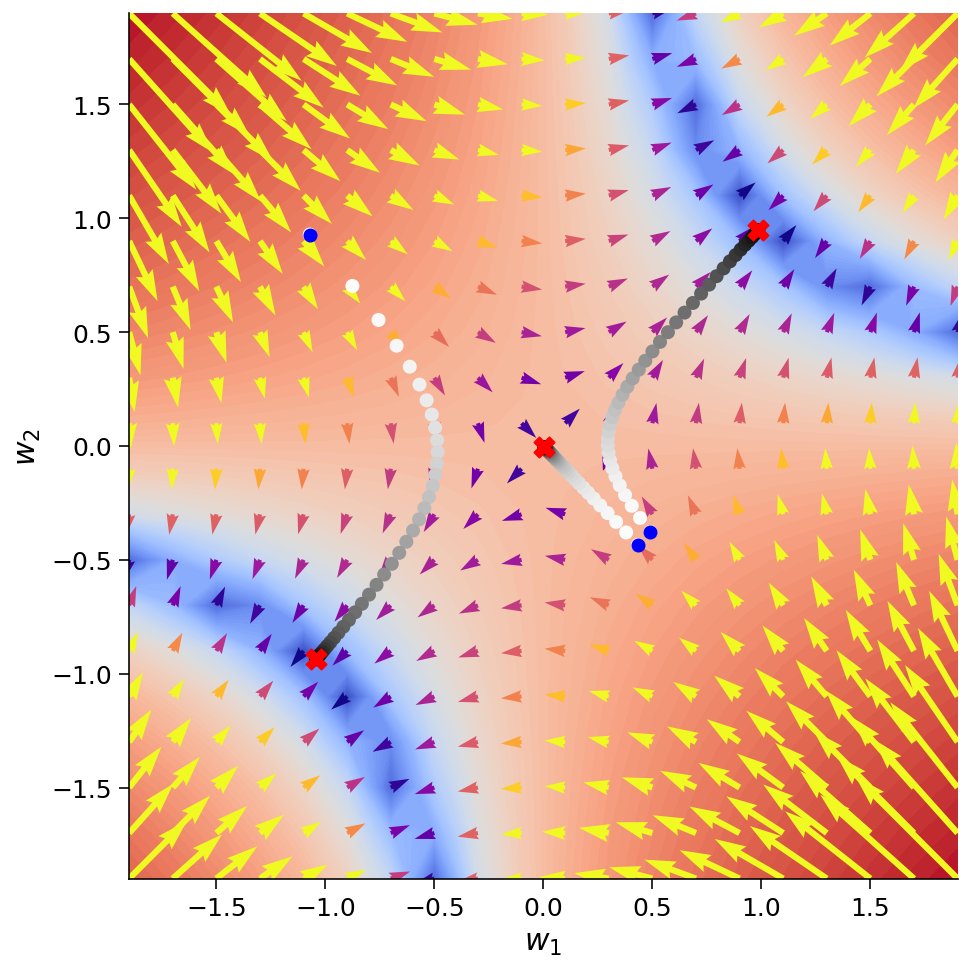

In [13]:
plot_vector_field('all')

Here, we also visualize the loss landscape in a 3-D plot, with two training trajectories for different initial conditions.
Note: the trajectories from the 3D plot and the previous plot are independent and different.

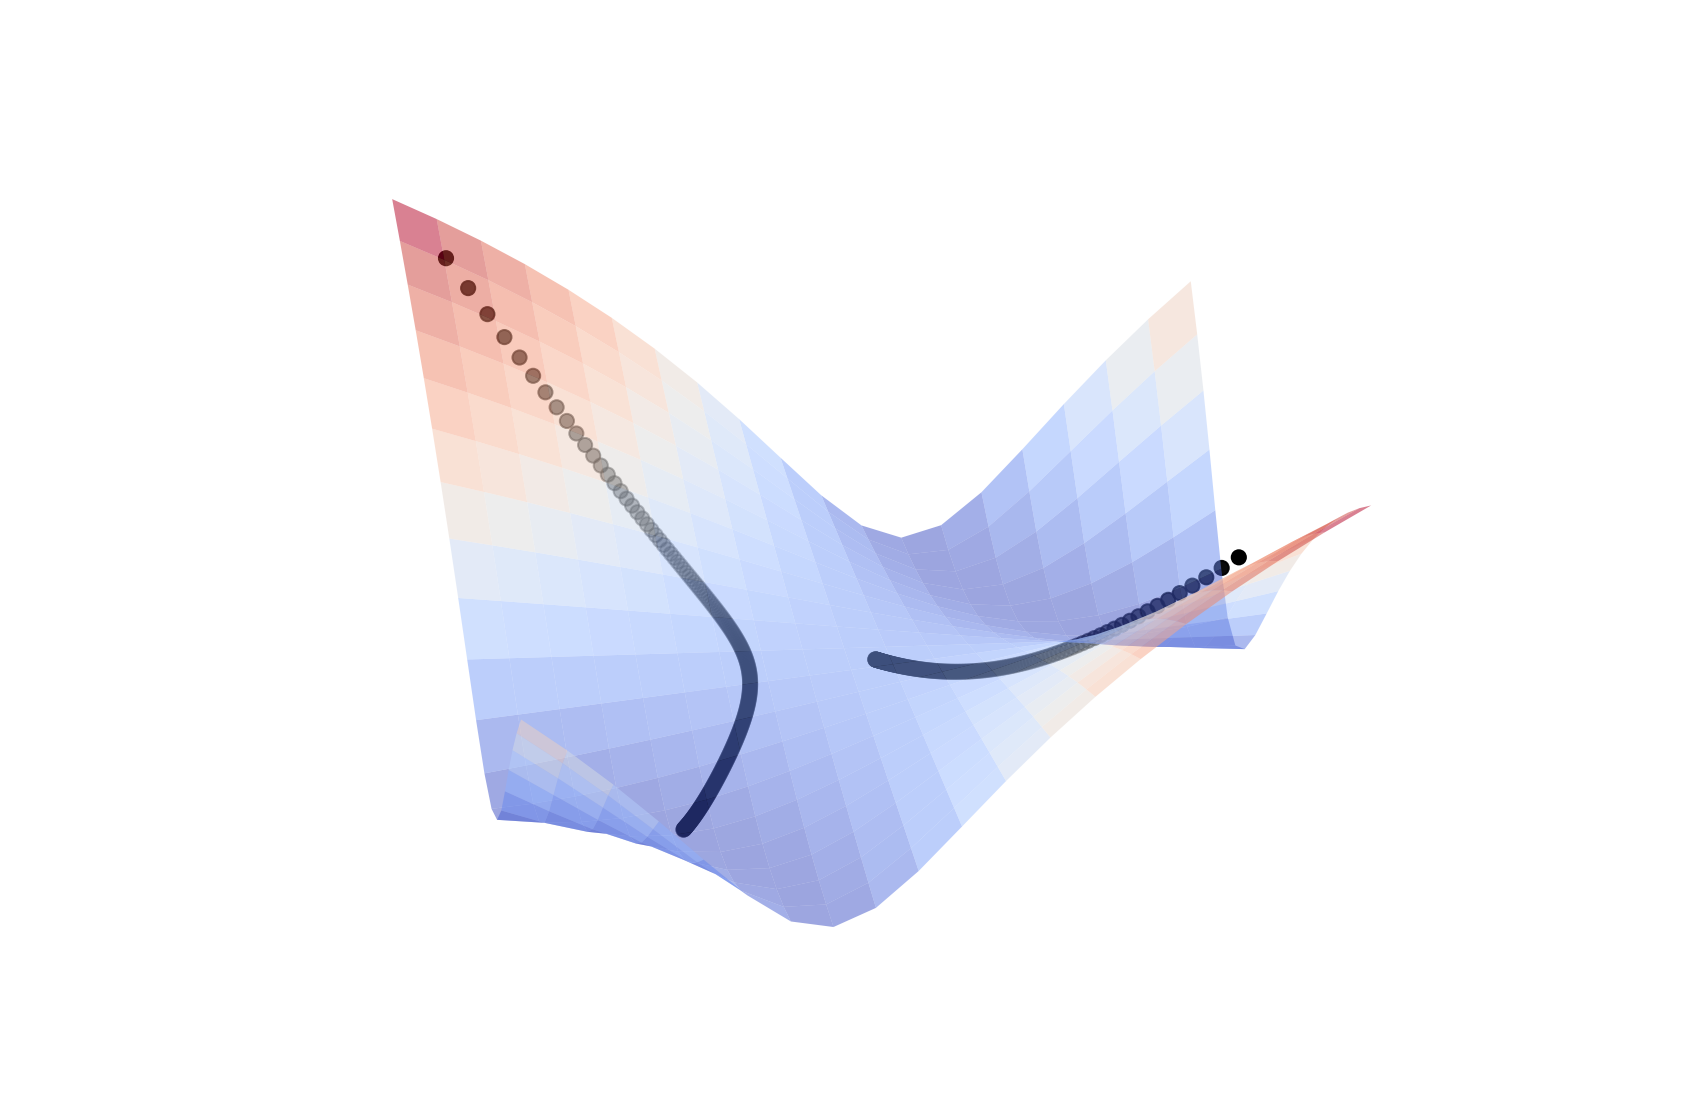

In [14]:
plot_loss_landscape()

Video available at https://youtu.be/Gu5RT4XHwpk


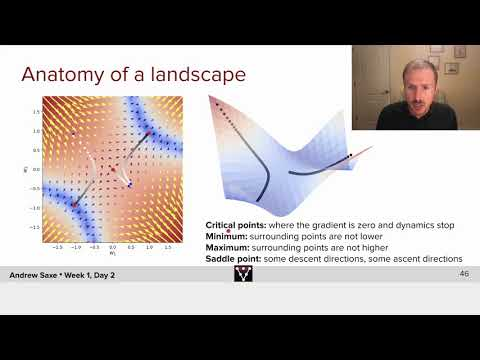

In [15]:
#@title Video 1.3: Training-Landscape Explained
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Gu5RT4XHwpk", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---
# Section 2: Depth, Learning rate, and initialization


Video available at https://youtu.be/qByBvDshi4A


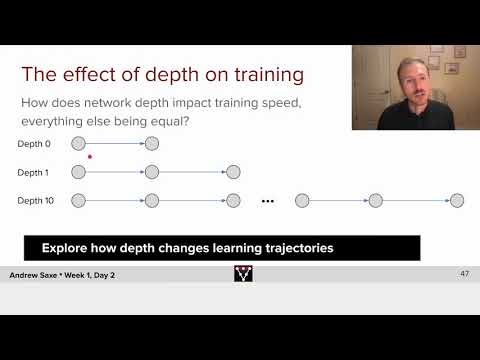

In [16]:
#@title Video 2.1: Effect of Depth
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="qByBvDshi4A", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

In the course of this summer school, we will see how powerful and versatile deep learning algorithms can be. But we will also realize how challenging the process of actually training deep networks can be. Successful deep learning models are often developed by a team of clever people, spending many many hours "designing" the architecture of their model, "tuning" learning hyperparameters, and finding effective initializations.

In this section, we look at three basic (but often not simple) challenges when approaching neural networks: depth, learning rate, and initialization.

## Section 2.1: The effect of depth

Video available at https://youtu.be/llZq5R_QZZE


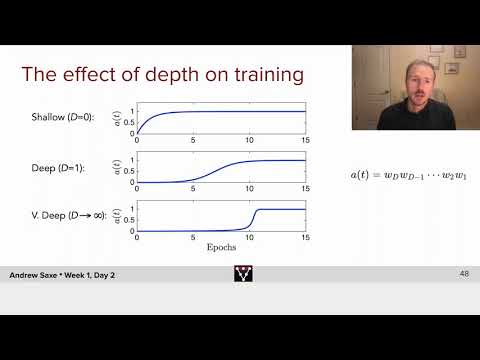

In [17]:
#@title Video 2.2: Effect of Depth Explained
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="llZq5R_QZZE", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

In 1989, George Cybenko published the paper *Approximation by superpositions of a sigmoidal function* (a highly recommended paper), mathematically proving that:

> arbitrary decision regions can be arbitrarily well approximated by continuous feedforward neural networks with only a single internal, hidden layer and any continuous sigmoidal nonlinearity.

So if a shallow neural net can approximate any function, Why might depth be useful? What makes a network or learning system "deep"? Sometimes depth seems like magic. Depth can change the functions a network can represent, the way a network learns, and how a network generalizes to unseen data. 

But first, lets look at the challenges that depth poses in training a neural network. Imagine a single input, single output linear network with 50 hidden layers but only one neuron per layer. The output of the network is easy to calculate:

$$ y_p = x \cdot w_1 \cdot w_2 \cdot \cdot \cdot w_{50} $$

If the initial value for all the weights is $w_i = 2$, the prediction for $x=1$ would be $y_p = 2^{50} \approx 1.1256 \times 10^{15}$. Also, for weights initialized to $w_i = 0.5$, the output is $y_p = 0.5^{50} \approx 8.88 \times 10^{-16}$. Similarly, if you recall the chain rule, as the graph gets deeper, the number of elements in the chain multiplication increases, leading to exploding or vanishing gradients. To avoid such numerical vulnerablities which could impair our training algorithm, we need to understand their effect.



### Exercise 2.1: Depth widget

Use the widget to explore the impact of depth on the training curve (loss evolution) of a deep but narrow neural network and discuss your findings with your pod.

In [18]:
# #@markdown Make sure you execute this cell to enable the widget!

_ = interact(depth_widget,
    depth = IntSlider(min=10, max=51, step=5, value=25, continuous_update=False))

interactive(children=(IntSlider(value=25, continuous_update=False, description='depth', max=51, min=10, step=5…

**Questions**:
Which networks trained the fastest? Did all networks ‘work’ eventually? What is the shape of their learning trajectory?

## Section 2.2: Choosing a learning rate

Video available at https://youtu.be/KsfCHSaFwPk


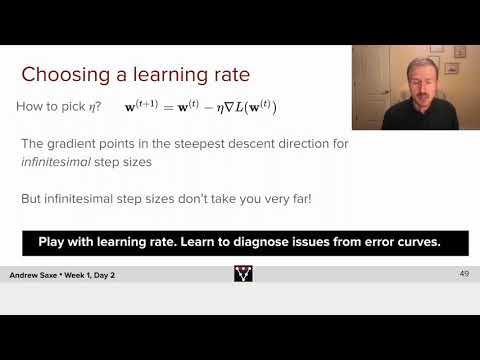

In [19]:
#@title Video 2.3: Learning Rate
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="KsfCHSaFwPk", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Learning rate is the basic, but not the only, hyperparameter of most of optimization algorithms. Sometimes the only option is to try all the possibilities, but sometimes knowing some basic trade offs will help guide our seach for the optimums.

### Exercise 2.2: Learning rate widget

Use the widget to explore the impact of learning rate $\eta$ on the training curve (loss evolution) of a deep but narrow neural network and discuss your findings with your pod.

In [20]:
# #@markdown Make sure you execute this cell to enable the widget!

_ = interact(lr_widget,
    lr = FloatSlider(min=0.005, max=0.045, step=0.005, value=0.005,
                     continuous_update=False, readout_format='.3f', description='η'))

interactive(children=(FloatSlider(value=0.005, continuous_update=False, description='η', max=0.045, min=0.005,…

Video available at https://youtu.be/c5P66SjqNmM


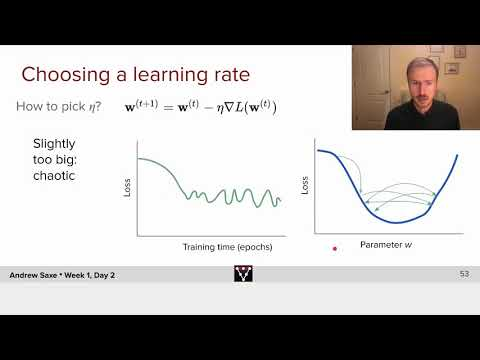

In [21]:
#@title Video 2.4: Learning Rate Explained
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="c5P66SjqNmM", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

**Questions**:
Can we say that larger learning rates always lead to faster learning? Why not? 

### Exercise 2.3: Depth-Learning-Rate-Interplay


Video available at https://youtu.be/EpW0SaesiyQ


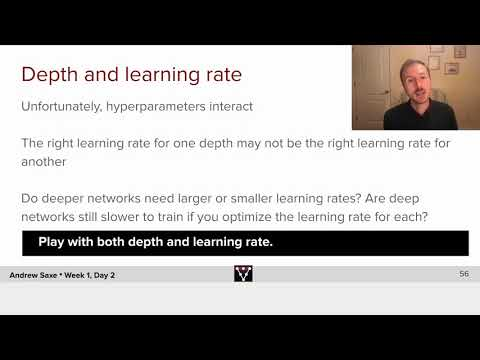

In [22]:
#@title Video 2.5: Depth and Learning Rate Interplay
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="EpW0SaesiyQ", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


Use the widgets to explore the interplay between learning rate $\eta$ and depth while searching for an smooth and fast training regime for our deep but narrow neural network and discuss your findings with your pod.

In [23]:
# #@markdown Make sure you execute this cell to enable the widget!

_ = interact(depth_lr_interplay,
             depth = IntSlider(min=10, max=51, step=5, value=25, continuous_update=False),
             lr = FloatSlider(min=0.005, max=0.1, step=0.005, value=0.005,
                     continuous_update=False, readout_format='.3f', description='η'))

interactive(children=(IntSlider(value=25, continuous_update=False, description='depth', max=51, min=10, step=5…

**Questions**: Can you explain the relationship between the depth and optimal learning rate?

Video available at https://youtu.be/XB8drYSXnww


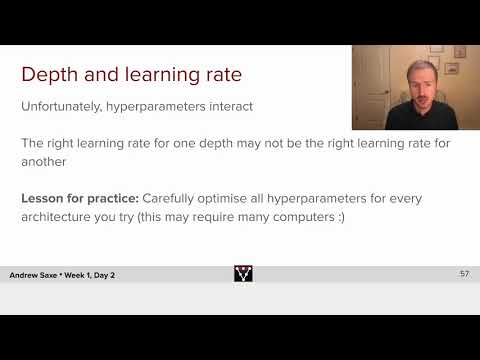

In [24]:
#@title Video 2.7: Depth and Learning Rate Interplay Explained
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="XB8drYSXnww", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Section 2.3: Initialisation matters

Video available at https://youtu.be/_vzihIakBHY


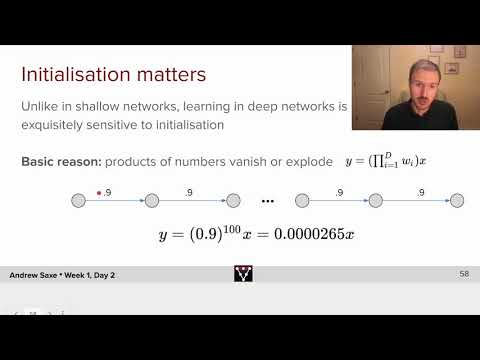

In [25]:
#@title Video 2.8: Initialization Matters
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="_vzihIakBHY", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

We’ve seen, even in the simplest of cases, that depth can slow learning. Why? Based on the chain rule, gradients are multiplied by current weight at each layer, so the product can vanish or explode. Therefore, weight initialisation is a fundamentally important hyperparameter.

The figure below shows the effect of initialization on the speed of learning for the deep but narrow LNN. We have excluded the initializations that could lead to nummerical errors such as `nan` or `inf` which are the consequence of smaller or larger initializations.

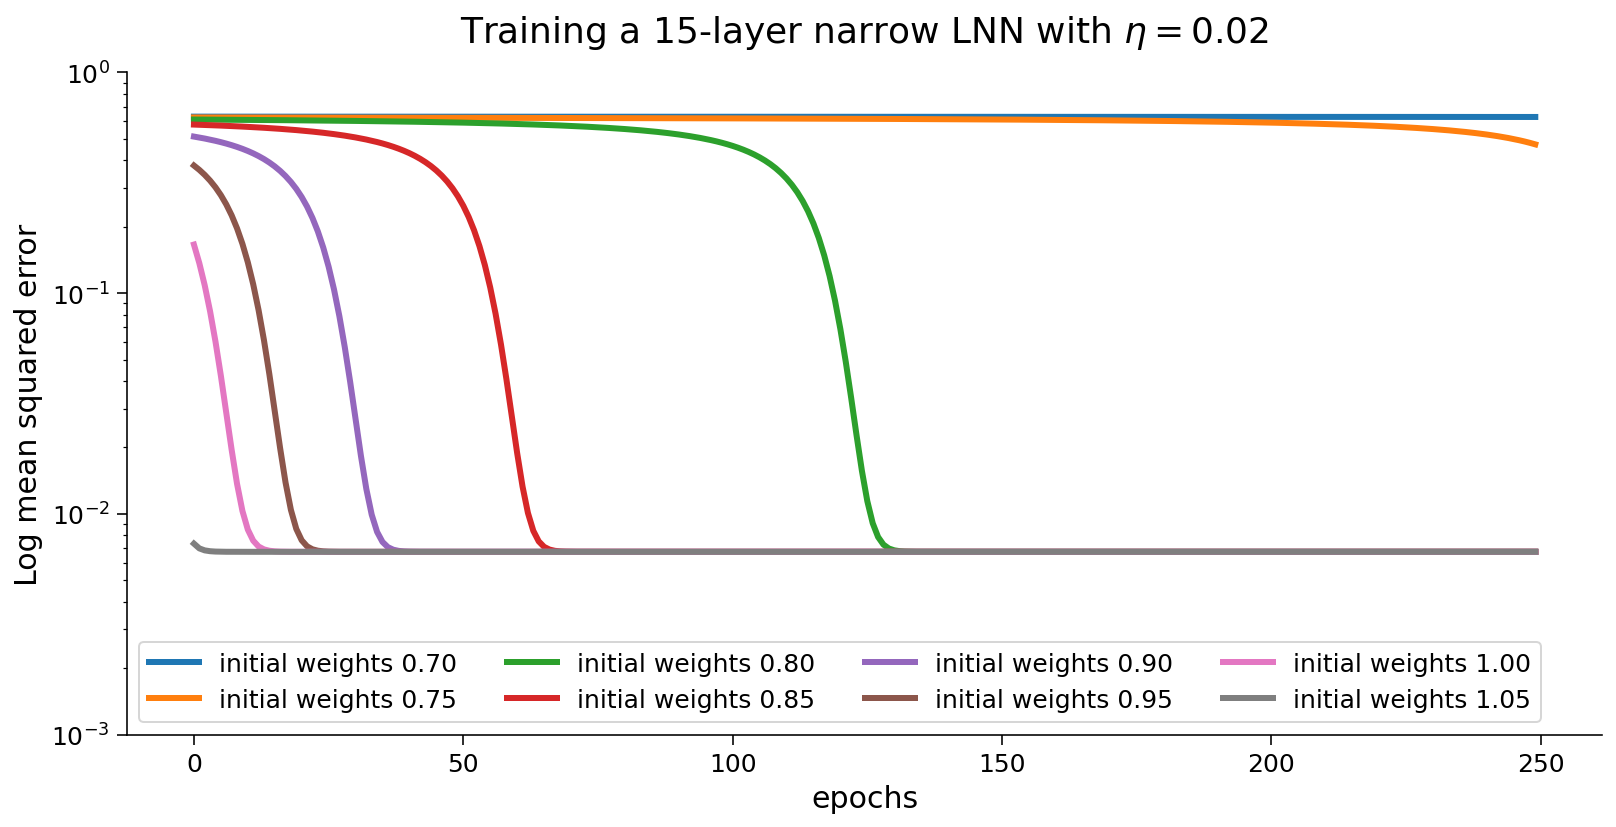

In [26]:
# #@markdown Make sure you execute this cell to see the figure!

plot_init_effect()

### Exercise 2.3: Hyperparameter interaction

Finally, lets put everything we learned together and find best initial weight and learning rate for a given depth. By now you should have learned the interactions and know how to find the optimal values quickly. If you get `numerical overflow` warnings, don't be discouraged! They are often caused by "exploding" or "vanishing" gradients.

In [27]:
# #@markdown Make sure you execute this cell to enable the widget!

_ = interact(depth_lr_init_interplay,
             depth = IntSlider(min=10, max=51, step=5, value=25, continuous_update=False),
             lr = FloatSlider(min=0.001, max=0.1, step=0.005, value=0.005,
                     continuous_update=False, readout_format='.3f', description='η'),
             init_weights = FloatSlider(min=0.1, max=3.0, step=0.1, value=0.9,
                     continuous_update=False, readout_format='.3f', description='initial weights'))

interactive(children=(IntSlider(value=25, continuous_update=False, description='depth', max=51, min=10, step=5…

**Questions**: Did you experience any surprising behaviour or difficulty finding the optimal parameters?

Video available at https://youtu.be/UEguqaYYQso


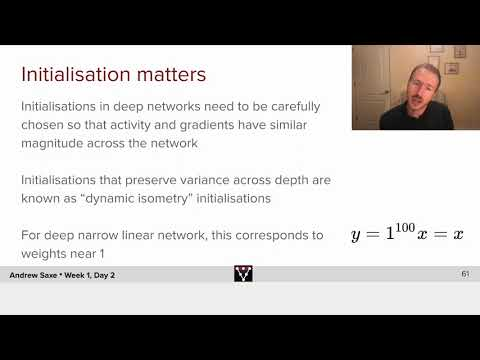

In [28]:
#@title Video 2.9: Initialization Matters Explained
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="UEguqaYYQso", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Section 2.4: Initialization of deep high dimensional Networks (Optional)

**PyTorch:**  
the learnable parameters (weights and biases) of a linear layer with shape ($n_{in}$, $n_{out}$) are initialized with values sampled from uniform distribution:

\begin{equation}
\mathcal{U}\left( -\sqrt{\dfrac{1}{n_{in}}}, ~~\sqrt{\dfrac{1}{n_{in}}}  \right)
\end{equation}

for more details, see [torch.nn.linear](https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py) and [torch.nn.init](https://pytorch.org/docs/stable/nn.init.html).


**Xavier:**  
the learnable parameters (weights and biases) of a layer with shape ($n_{in}$, $n_{out}$) are initialized with values sampled from either normal distributions:

$$\mathcal{N}\left(\mu=0, ~~\sigma=\sqrt{\dfrac{2}{n_{in} + n_{out}}} \right)$$

or uniform distribution:

$$\mathcal{U}\left(- \sqrt{\dfrac{6}{n_{in} + n_{out}}},~~ \sqrt{\dfrac{6}{n_{in} + n_{out}}}\right)$$

which is named after by *Xavier Glorot*, [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a.html).


Video available at https://youtu.be/Nv-eI9yy2O0


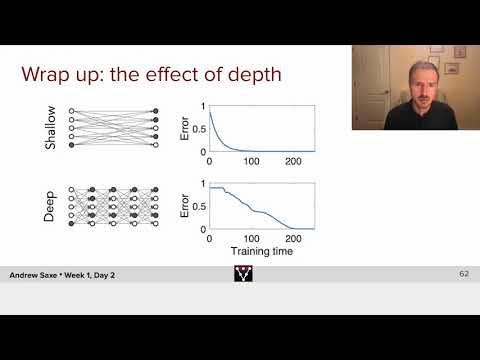

In [29]:
#@title Video 2.10: Wrap-up
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Nv-eI9yy2O0", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video